In [17]:
import pandas as pd
import numpy as np
import sys
import os
import io
import sklearn
from sklearn import tree, metrics, model_selection, preprocessing
from IPython.display import Image, display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.tree import _tree
from sklearn.cluster import KMeans

zipcode = 98027

In [22]:
path = r"kc_house_data.csv"

arquivo = pd.read_csv(path, sep=",",encoding='utf-8')
arquivo[['zipcode']] = arquivo[['zipcode']].astype(int)
arquivo.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [23]:
arq_grupo = arquivo.copy()
arq_grupo = arq_grupo[arq_grupo['zipcode']==zipcode].reset_index(drop=True)
arq_grupo.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,8562750320,20141110T000000,580500.0,3,2.50,2320,3980,2.0,0,0,...,8,2320,0,2003,0,98027,47.5391,-122.070,2580,3980
1,9545230140,20140725T000000,597750.0,4,2.50,2310,9624,2.0,0,0,...,8,2310,0,1984,0,98027,47.5386,-122.053,1940,9636
2,9545240070,20150428T000000,660500.0,4,2.25,2010,9603,1.0,0,0,...,8,1440,570,1986,0,98027,47.5343,-122.054,2060,9793
3,3224079105,20140806T000000,430000.0,2,2.50,2420,60984,2.0,0,0,...,7,2420,0,2007,0,98027,47.5262,-121.943,1940,193842
4,2617300160,20140812T000000,420000.0,3,2.00,2020,38332,1.0,0,0,...,7,1010,1010,1975,0,98027,47.4582,-122.023,2110,36590


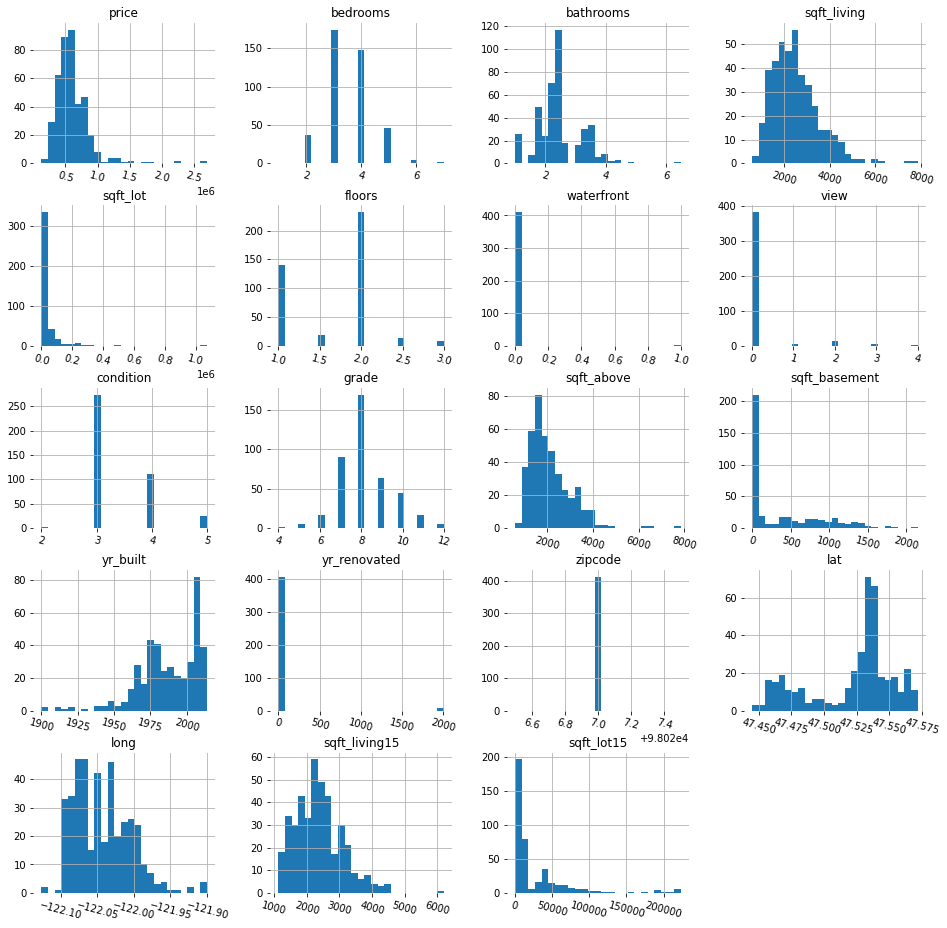

In [24]:
df1=arq_grupo[['price', 'bedrooms', 'bathrooms', 'sqft_living',
    'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
    'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
    'lat', 'long', 'sqft_living15', 'sqft_lot15']]

h = df1.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15)
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

In [25]:
arq_tree = arq_grupo.copy()

In [26]:
arq_tree = arq_tree.dropna()
arq_tree.shape #Temos 412 linhas e 21 colunas

(412, 21)

In [27]:
arq_tree.loc[:,'price_sq_meter'] = arq_tree.loc[:,'price']/arq_tree.loc[:,'sqft_living']
arq_tree.loc[:,'zscore'] =  (arq_tree.loc[:,'price_sq_meter'] - arq_tree['price_sq_meter'].mean())/arq_tree['price_sq_meter'].std(ddof=0)
arq_teste = arq_tree.iloc[-10:].reset_index(drop=True)

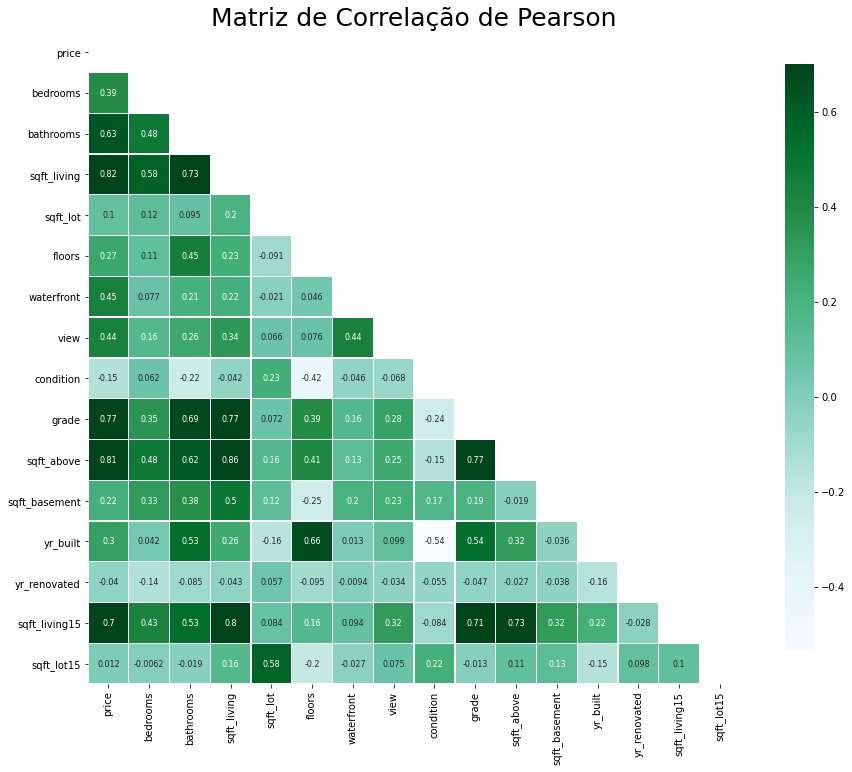

In [28]:
arq_tree =  arq_tree.iloc[:-10]
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'sqft_living15','sqft_lot15']

mask = np.zeros_like(arq_tree[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Matriz de Correlação de Pearson',fontsize=25)

sns.heatmap(arq_tree[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

In [29]:
def normalized_score(line):
    
    """0: casa na média
       1: casa barata
       2: casa cara"""
    
    i = 0.7
    if abs(line.zscore)<=i:
        return 0
    elif line.zscore>i:
        return 2
    else:
        return 1
    
arq_tree['zscore_norm']  = arq_tree.apply(normalized_score,axis=1)
arq_teste['zscore_norm']  = arq_teste.apply(normalized_score,axis=1)

arq_tree.columns.values

array(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'price_sq_meter', 'zscore', 'zscore_norm'], dtype=object)

In [30]:
lista_colunas = ['bedrooms','sqft_above','grade','bathrooms','waterfront','view','sqft_living','sqft_living15']
colunas_novas = []
lista_medias = {}

def kmeans_func(coluna):
    
    pricesT=[]
    prices= arq_tree[coluna].values
    
    for price in prices:
        pricesT.append([price])
    kmeans_price = KMeans(n_clusters= 2, random_state=0).fit(pricesT)
    
    media = kmeans_price.cluster_centers_
    media = (media[0][0]+media[1][0])/2
    
    prices_disc=[]
    for price in prices:
        price_disc = kmeans_price.predict([[price]])
        prices_disc.append(price_disc[0])
    
    colunas_novas.append(coluna+'_discretized')
    arq_tree[coluna+'_discretized']= prices_disc
    
    # Adding a new key value pair
    lista_medias.update({coluna+'_discretized': round(media,2)})

for col in lista_colunas:
    kmeans_func(col)

locations= arq_tree[['lat','long']].values
kmeans_loc = KMeans(n_clusters = 2, random_state=0).fit(locations)

locations_disc=[]

for location in locations:
    location_disc = kmeans_loc.predict([location])
    locations_disc.append(location_disc[0])

location_teste = []
locations= arq_teste[['lat','long']].values
for location in locations:
    location_disc = kmeans_loc.predict([location])
    location_teste.append(location_disc[0])

arq_teste['locations_discretized'] = location_teste
arq_teste.to_csv('arquivo_teste.csv')

arq_tree['locations_discretized']=locations_disc
colunas_novas+=['locations_discretized']

lista_medias.update({'locations_discretized': 0.5})

perguntas = {'bedrooms_discretized': r'number of bedrooms',
 'sqft_above_discretized': 'number of sqft above',
 'grade_discretized': "grade",
 'bathrooms_discretized':'number of bathrooms',
 'waterfront_discretized': 'waterfront classification',
 'view_discretized': 'view classified as',
 'sqft_living_discretized': 'number of sqft living',
 'sqft_living15_discretized': 'number sqft living 15',
  'locations_discretized':'location discretized'}


In [31]:
y = arq_tree['zscore_norm'].copy()  #objetivo ou coluna target
x = arq_tree[colunas_novas]  #colunas que iremos buscar relacoes

# Dividindo os dados aleatoriamente em 90% training e 10% test
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.10, random_state=0)

# Treinando a árvore de decisão
dtree = tree.DecisionTreeClassifier(max_depth= 6,random_state = 1,min_impurity_decrease= 0.0015, min_samples_split= 8)
clf = dtree.fit(X_train, y_train)

In [32]:
#Testando nosso modelo

y_pred = dtree.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.78


In [33]:
text_representation = tree.export_text(dtree, feature_names = colunas_novas, show_weights = True)
s = io.StringIO(text_representation)
with open('fileName.csv', 'w') as f:
    for line in s:
        f.write(line)        

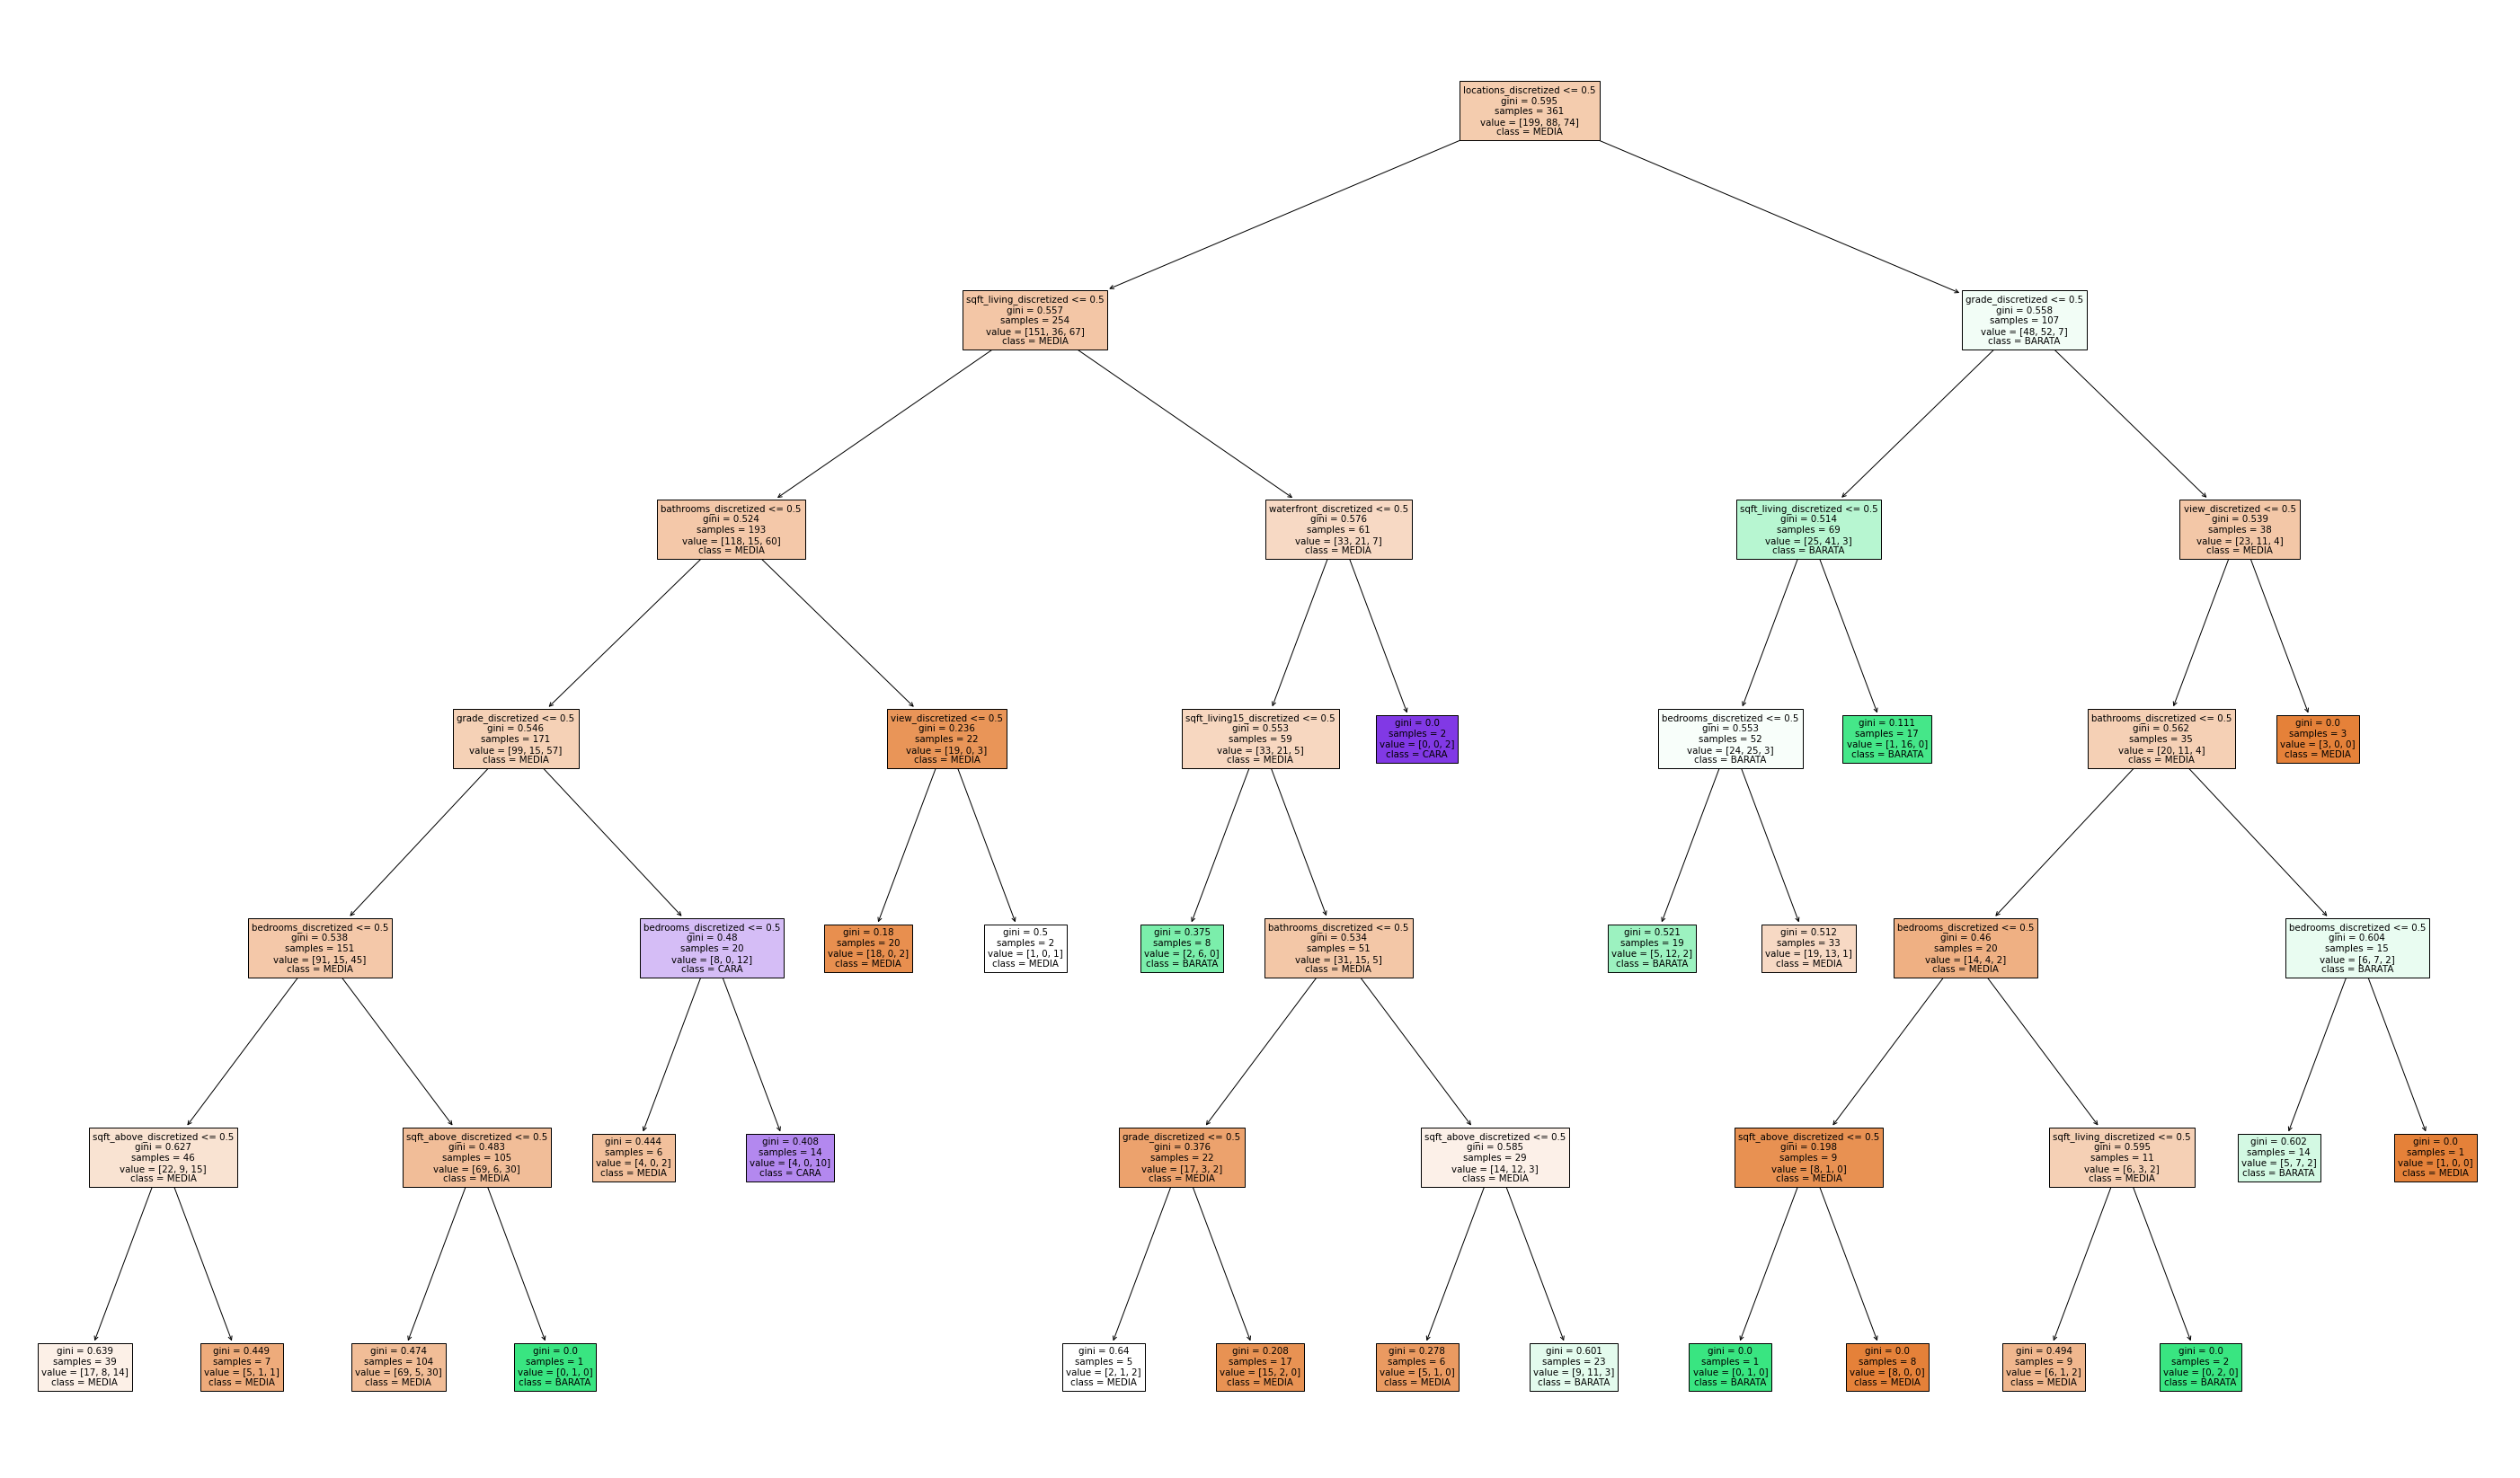

In [34]:
fig = plt.figure(figsize=(50,30))
_ = tree.plot_tree(dtree, 
                   feature_names=colunas_novas,  
                   class_names = ['MEDIA','BARATA','CARA'],
                   filled=True)

In [35]:
#Escreve arquivo .dot para gerar a 

export_graphviz(clf, out_file='tree.dot', 
                feature_names = colunas_novas,
                class_names = ['MEDIA','BARATA','CARA'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [36]:
#https://gist.github.com/eherrerosj/ed3400b06f3c5c7668c62653e2a695c2
#Local que encontramos o código no GitHub

texto = ['\n']

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        global texto
        indent = "    " * (depth+1)
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            texto.append(rf"{indent}{name.replace('_','')} = float(validaEntrada('Is the {perguntas[name]} <= {lista_medias[name]}?'))")
            texto.append(rf"{indent}if {name.replace('_','')} <= {threshold}:")
            recurse(tree_.children_left[node], depth + 1)
            texto.append(rf"{indent}else:  # if {name.replace('_','')} > {threshold}")
            recurse(tree_.children_right[node], depth + 1)
        else:
            texto.append("{}return({})".format(indent, np.argmax(tree_.value[node])))

    recurse(0, 1)
tree_to_code(dtree,colunas_novas)
 
with open('templateEngine.py','r', encoding="utf-8") as reader, open('engine.py', 'w',encoding="utf-8") as writer:
    arquivo = reader.readlines()
    writer.writelines(arquivo)
    for line in texto:
        writer.write(line)
        writer.write("\n")
    
writer.close()

def tree(bedrooms_discretized, sqft_above_discretized, grade_discretized, bathrooms_discretized, waterfront_discretized, view_discretized, sqft_living_discretized, sqft_living15_discretized, locations_discretized):


In [ ]:
sys.path.append(r'C:\Users\mathe\Documents\QS_2020_UFABC\ProgramacaoEstruturada\Code')
from engine import chatbotEngine

while True:
    
    resposta = chatbotEngine()
    
    if resposta ==0:
        print('Esta casa deve estar na média!\n')
    elif resposta ==1:
        print('Esta casa é barata!\n')
    else:
        print('Esta casa é cara!\n')
    
    entrada = int(input('Digite 1 para Continuar e qualquer outro valor numérico para sair...\n'))
    
    if entrada == 1:
        continue
    else:
        print('Tchau! Até a próxima amigx!\n')
        break
        
print('FIM!')

INICIANDO.....

Olá Queridxs! Prazer, sou o UFBot, vou te ajudar a analisar o preço de algumas casas. Vamos lá?

Digite 0 para SIM, 1 para NÃO e 2 para VOLTAR AO INÍCIO

Is the location discretized <= 0.5?
0
Digite 0 para SIM, 1 para NÃO e 2 para VOLTAR AO INÍCIO

Is the number of sqft living <= 2858.22?
1
Digite 0 para SIM, 1 para NÃO e 2 para VOLTAR AO INÍCIO

